This notebook: 
1. loads disp rate maps for intervals. Choose small regions/boxes to do following steps in. Do a few.
2. loads amp dispersion, wrap error, and high pass phase files.
3. set ranges of values for each criteria above.
4. loop through the ranges of criteria thresholds, count number of pix are in the range, calculate distribution of velocities in that range, save the mean, median, upper quartile, lower quartile, min, and max for box and whisker plot. 
5. Plot the range (center of each range) vs. the velocities (boxes and whiskers)
6. 

This notebook was copied and edited on 7-3-23.

***

In [ ]:
# load reference pixels mask 
maskFile = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_northern_shore_LS_for_unwrapping/masks/ref_pixels_mask.r4'
ds = gdal.Open(maskFile,gdal.GA_ReadOnly)
ref_mask = ds.GetRasterBand(1).ReadAsArray(0,0,dx,dy)
mask_y,mask_x = np.nonzero(ref_mask)
print('Reference pixel mask loaded.')

In [1]:
# import stuff
import os,sys
import glob
import pandas as pd
from osgeo import gdal
import datetime 
from datetime import datetime
from datetime import timedelta
from dateutil import parser
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
%matplotlib  widget 

In [2]:
# choose 'filt' or 'unfilt'
key1 = 'unfilt'
# choose one: 'avg_val' or 'ref_box' or 'ref_pix'
key2 = 'ref_pix'

In [3]:
# this one is to pick out the dates 
datesDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/'
# shape of unwrapped igrams
dx = 3000
dy = 750

# larger cropped area with western mountains 
dx = 4000
dy = 1100

# load in dates, make sure they are in order
dates = [os.path.basename(x) for x in glob.glob(datesDir+"SLC_vh/2*")]; dates = sorted(dates)
nd = len(dates); numIgrams = nd-1
# set the driver first, only do once.
#driver=gdal.GetDriverByName('ISCE')

In [4]:
start_indices = [0,47,108,147,0,0,107]
end_indices = [46,107,146,numIgrams,88,numIgrams,153]
num_intervals = len(end_indices)
# the last one I just added (4-12-23) as a totally dry period

for i in range(num_intervals):
    print('interval '+str(i)+': '+str(dates[start_indices[i]])+'-'+str(dates[end_indices[i]]))
print(str(num_intervals)+' intervals.')

interval 0: 20170510-20181125
interval 1: 20181207-20200412
interval 2: 20200418-20201208
interval 3: 20201214-20220108
interval 4: 20170510-20191220
interval 5: 20170510-20220108
interval 6: 20200412-20210119
7 intervals.


In [5]:
disp_rates = np.ndarray((num_intervals,dy,dx),dtype='float')
disp_rates_errors = np.ndarray((num_intervals,dy,dx),dtype='float')
saveDir = '/data/ocp4/LagunaSalada/Data_and_Figs/12_rate_inversions/disp_rate_maps_with_western_mtns/'
for j in range(num_intervals):    
    # read in disp rate file + rmse file
    fileName = 'interval_'+str(j)+'_'+key1+'_weighted_ref_to_'+key2+'.r4'
    errorFileName = 'interval_'+str(j)+'_'+key1+'_weighted_ref_to_'+key2+'_residual_std.r4'
    f1 = gdal.Open(saveDir+fileName, gdal.GA_ReadOnly)
    disp_rates[j] = f1.ReadAsArray()
    f1 = None
    f1 = gdal.Open(saveDir+errorFileName, gdal.GA_ReadOnly)
    disp_rates_errors[j] = f1.ReadAsArray()
    f1 = None
    print('interval '+str(j)+' disp rate map + errors loaded.')

interval 0 disp rate map + errors loaded.
interval 1 disp rate map + errors loaded.
interval 2 disp rate map + errors loaded.
interval 3 disp rate map + errors loaded.
interval 4 disp rate map + errors loaded.
interval 5 disp rate map + errors loaded.
interval 6 disp rate map + errors loaded.


In [6]:
# define boxes I want to look at 
from matplotlib.patches import Rectangle
box1x = [2300,2800];  box1dx = box1x[1]-box1x[0]
box1y = [300, 400];   box1dy = box1y[1]-box1y[0]
box2x = [1500, 2000]; box2dx = box2x[1]-box2x[0]
#box2y = [75, 175];    
box2y = [125, 200];   box2dy = box2y[1]-box2y[0]
box3x = [3500, 4000];  box3dx = box3x[1]-box3x[0]
box3y = [725, 800];   box3dy = box3y[1]-box3y[0]
box4x = [2150,2650];  box4dx = box4x[1]-box4x[0]
box4y = [600, 700];   box4dy = box4y[1]-box4y[0]

In [7]:
# define second set of boxes. First ones weren't good enough.
from matplotlib.patches import Rectangle
box1x = [3000,3500];  box1dx = box1x[1]-box1x[0]
box1y = [300, 400];   box1dy = box1y[1]-box1y[0]
box2x = [2000, 2500]; box2dx = box2x[1]-box2x[0] 
box2y = [125, 200];   box2dy = box2y[1]-box2y[0]
box3x = [3500, 4000];  box3dx = box3x[1]-box3x[0]
box3y = [650, 750];   box3dy = box3y[1]-box3y[0]
box4x = [2500,3000];  box4dx = box4x[1]-box4x[0]
box4y = [600, 700];   box4dy = box4y[1]-box4y[0]

boxes = ['box1','box2','box3','box4']
numBoxes=len(boxes)
print(str(numBoxes)+' boxes.')

4 boxes.


In [8]:
# define third set of boxes. First ones weren't good enough.
from matplotlib.patches import Rectangle
box1x = [3500, 4000];  box1dx = box1x[1]-box1x[0]
box1y = [425, 525];   box1dy = box1y[1]-box1y[0]
box2x = [3500, 4000]; box2dx = box2x[1]-box2x[0] 
box2y = [200, 300];   box2dy = box2y[1]-box2y[0]
box3x = [3500, 4000];  box3dx = box3x[1]-box3x[0]
box3y = [0, 100];   box3dy = box3y[1]-box3y[0]
box4x = [3500, 4000];  box4dx = box4x[1]-box4x[0]
box4y = [1000,1100];   box4dy = box4y[1]-box4y[0]

boxes = ['box1','box2','box3','box4']
numBoxes=len(boxes)
print(str(numBoxes)+' boxes.')

4 boxes.


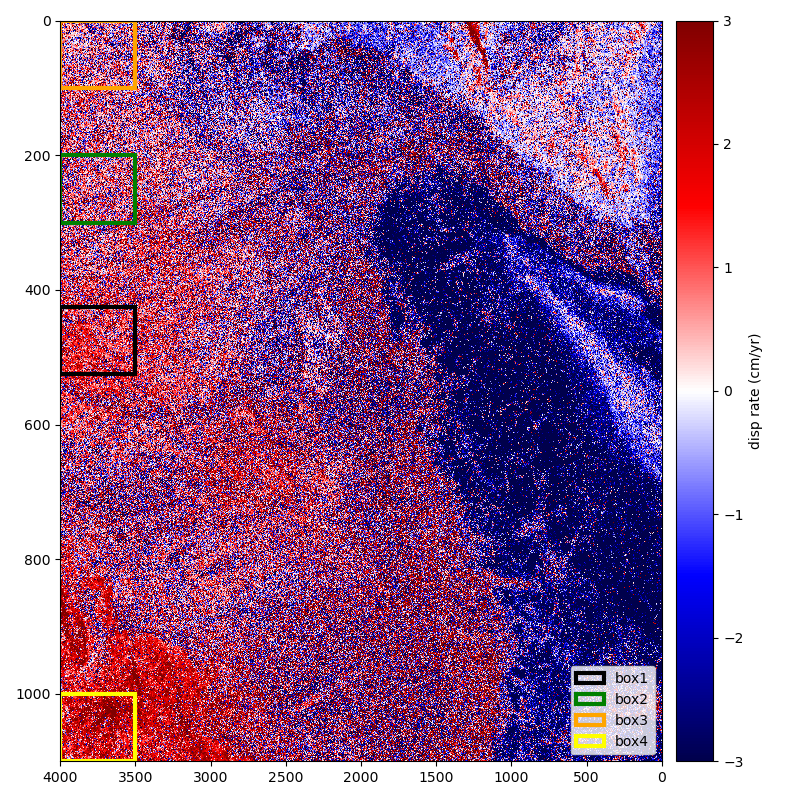

In [9]:
# plot them.
plt.figure(figsize=(8,8),tight_layout=True)
plt.imshow(np.mean(disp_rates,axis=0), aspect='auto', vmin=-3.0,vmax=3.0,\
            interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.set_cmap('seismic')
plt.xlim([dx,0]); plt.ylim([dy,0])
#plt.xticks([]); plt.yticks([])
plt.gca().add_patch(Rectangle((box1x[0],box1y[0]),box1dx,box1dy,edgecolor='k',facecolor='none',lw=3,label='box1'))
plt.gca().add_patch(Rectangle((box2x[0],box2y[0]),box2dx,box2dy,edgecolor='green',facecolor='none',lw=3,label='box2'))
plt.gca().add_patch(Rectangle((box3x[0],box3y[0]),box3dx,box3dy,edgecolor='orange',facecolor='none',lw=3,label='box3'))
plt.gca().add_patch(Rectangle((box4x[0],box4y[0]),box4dx,box4dy,edgecolor='yellow',facecolor='none',lw=3,label='box4'))
plt.legend(loc='lower right')
plt.show()

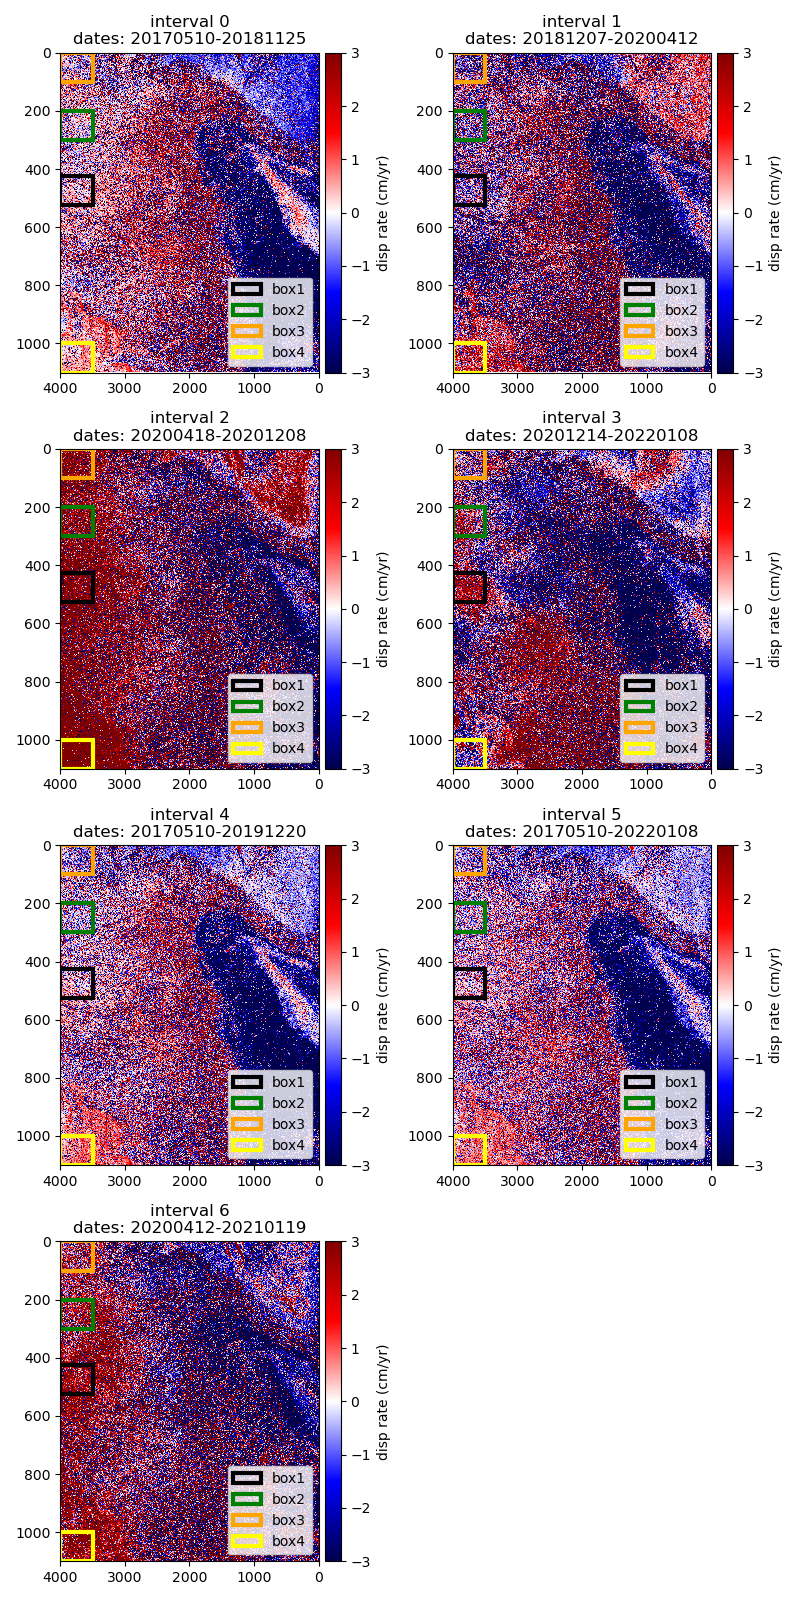

In [10]:
# plot them.
plt.figure(figsize=(8,16),tight_layout=True); count=1
for i in range(num_intervals):
    plt.subplot(4,2,count)
    plt.imshow(disp_rates[i], aspect='auto', vmin=-3.0,vmax=3.0,\
                interpolation='nearest')
    plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
    plt.set_cmap('seismic')
    plt.xlim([dx,0]); plt.ylim([dy,0])
    #plt.xticks([]); plt.yticks([])
    plt.gca().add_patch(Rectangle((box1x[0],box1y[0]),box1dx,box1dy,edgecolor='k',facecolor='none',lw=3,label='box1'))
    plt.gca().add_patch(Rectangle((box2x[0],box2y[0]),box2dx,box2dy,edgecolor='green',facecolor='none',lw=3,label='box2'))
    plt.gca().add_patch(Rectangle((box3x[0],box3y[0]),box3dx,box3dy,edgecolor='orange',facecolor='none',lw=3,label='box3'))
    plt.gca().add_patch(Rectangle((box4x[0],box4y[0]),box4dx,box4dy,edgecolor='yellow',facecolor='none',lw=3,label='box4'))
    plt.legend(loc='lower right')
    plt.title('interval '+str(i)+'\ndates: '+str(dates[start_indices[i]])+'-'+str(dates[end_indices[i]]))
    count = count+1
plt.show()

Now load files:
1. amp dispersion
2. triplet unwrapping consistency/wrap errors
3. high pass phase 

In [11]:
loadDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/'

file_name = 'amp_dispersion.r4' 
f1 = gdal.Open(loadDir+file_name, gdal.GA_ReadOnly)
amp_dispersion = f1.ReadAsArray(); f1 = None
print('Amplitude dispersion for each pixel loaded.')

file_name = 'unfilt_unwrapped/wrap_err.i1' 
f1 = gdal.Open(loadDir+file_name, gdal.GA_ReadOnly)
wrap_err = f1.ReadAsArray(); f1 = None
print('wrap errors for each pixel loaded.')

file_name = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/hpcor.r4' 
f1 = gdal.Open(file_name, gdal.GA_ReadOnly)
hp = f1.ReadAsArray(); f1 = None
# cropped area
x1 = 18000; x2 = 14000
y1 = 2100; y2 = 1000
hp_phs = hp[y2:y1,x2:x1]
print('high pass phase for each pixel loaded.')

Amplitude dispersion for each pixel loaded.
wrap errors for each pixel loaded.
high pass phase for each pixel loaded.


Plot the three criteria: average behavior of each pixel over entire interval.

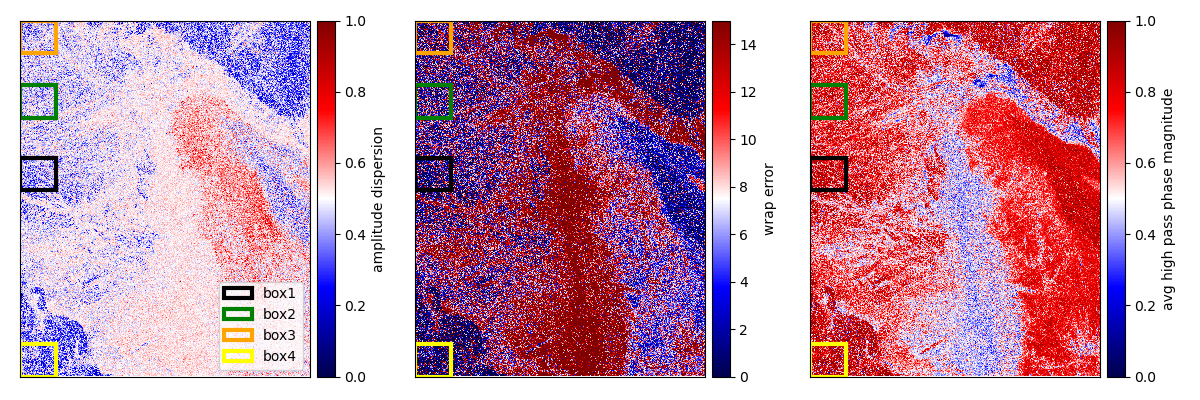

In [12]:
plt.figure(figsize=(12,4),tight_layout=True)
plt.subplot(1,3,1)
plt.imshow(amp_dispersion, aspect='auto',interpolation='nearest',vmin=0,vmax=1.0)
plt.colorbar(orientation='vertical',pad=0.02,label='amplitude dispersion')
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
plt.gca().add_patch(Rectangle((box1x[0],box1y[0]),box1dx,box1dy,edgecolor='k',facecolor='none',lw=3,label='box1'))
plt.gca().add_patch(Rectangle((box2x[0],box2y[0]),box2dx,box2dy,edgecolor='green',facecolor='none',lw=3,label='box2'))
plt.gca().add_patch(Rectangle((box3x[0],box3y[0]),box3dx,box3dy,edgecolor='orange',facecolor='none',lw=3,label='box3'))
plt.gca().add_patch(Rectangle((box4x[0],box4y[0]),box4dx,box4dy,edgecolor='yellow',facecolor='none',lw=3,label='box4'))
plt.legend(loc='lower right')
plt.subplot(1,3,2)
plt.imshow(wrap_err, aspect='auto',interpolation='nearest',vmin=0,vmax=15)
plt.colorbar(orientation='vertical',pad=0.02,label='wrap error')
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
plt.gca().add_patch(Rectangle((box1x[0],box1y[0]),box1dx,box1dy,edgecolor='k',facecolor='none',lw=3,label='box1'))
plt.gca().add_patch(Rectangle((box2x[0],box2y[0]),box2dx,box2dy,edgecolor='green',facecolor='none',lw=3,label='box2'))
plt.gca().add_patch(Rectangle((box3x[0],box3y[0]),box3dx,box3dy,edgecolor='orange',facecolor='none',lw=3,label='box3'))
plt.gca().add_patch(Rectangle((box4x[0],box4y[0]),box4dx,box4dy,edgecolor='yellow',facecolor='none',lw=3,label='box4'))
plt.subplot(1,3,3)
plt.imshow(hp_phs, aspect='auto',interpolation='nearest',vmin=0,vmax=1.0)
plt.colorbar(orientation='vertical',pad=0.02,label='avg high pass phase magnitude')
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
plt.gca().add_patch(Rectangle((box1x[0],box1y[0]),box1dx,box1dy,edgecolor='k',facecolor='none',lw=3,label='box1'))
plt.gca().add_patch(Rectangle((box2x[0],box2y[0]),box2dx,box2dy,edgecolor='green',facecolor='none',lw=3,label='box2'))
plt.gca().add_patch(Rectangle((box3x[0],box3y[0]),box3dx,box3dy,edgecolor='orange',facecolor='none',lw=3,label='box3'))
plt.gca().add_patch(Rectangle((box4x[0],box4y[0]),box4dx,box4dy,edgecolor='yellow',facecolor='none',lw=3,label='box4'))
plt.show()

Make a colormap where Nans are different color: try green.

In [13]:
seismic2 = plt.cm.get_cmap("seismic").copy()
seismic2.set_bad(color='green')
print('colormap made where NANs will be green.')

colormap made where NANs will be green.


In [14]:
# which time interval? 
j = 5

In [15]:
# choose one 
boxKey = 'box1'

if boxKey == 'box1':
    boxX = box1x;    boxY = box1y
    boxdx = box1dx;  boxdy = box1dy
    print('using box 1.')
elif boxKey == 'box2':
    boxX = box2x;    boxY = box2y
    boxdx = box2dx;  boxdy = box2dy   
    print('using box 2.')
elif boxKey == 'box3':
    boxX = box3x;    boxY = box3y
    boxdx = box3dx;  boxdy = box3dy  
    print('using box 3.') 
elif boxKey == 'box4':
    boxX = box4x;   boxY = box4y
    boxdx = box4dx; boxdy = box4dy
    print('using box 4.')   
     
print('box is '+str(boxdy)+' by '+str(boxdx)+' pixels. '+str(boxdx*boxdy)+' total.')

using box 1.
box is 100 by 500 pixels. 50000 total.


Pull out the chosen box section of the disp map and the criteria maps.

In [16]:
amp_disp_box = amp_dispersion[boxY[0]:boxY[1],boxX[0]:boxX[1]]
wrap_err_box = wrap_err[boxY[0]:boxY[1],boxX[0]:boxX[1]]
hp_phs_box = hp_phs[boxY[0]:boxY[1],boxX[0]:boxX[1]]
disps_box = disp_rates[j,boxY[0]:boxY[1],boxX[0]:boxX[1]]

print('values within box extracted.')

values within box extracted.


Find min, max, median, and 1sigma above, 1sigma below values for each dataset. 

In [17]:
print('Amp Dispersion:')
temp = amp_disp_box.flatten()
#print(np.shape(temp))
print('min: '+str(min(temp)))
print('max: '+str(max(temp)))
print('median: '+str(np.median(temp)))
print('mean: '+str(np.mean(temp)))
print('sigma: '+str(np.std(temp)))
print('median+3sigma: '+str(np.median(temp)+3*np.std(temp)))
print('median-3sigma: '+str(np.median(temp)-3*np.std(temp)))

print('\nWrap Error:')
temp = wrap_err_box.flatten()
#print(np.shape(temp))
print('min: '+str(min(temp)))
print('max: '+str(max(temp)))
print('median: '+str(np.median(temp)))
print('mean: '+str(np.mean(temp)))
print('sigma: '+str(np.std(temp)))
print('median+3sigma: '+str(np.median(temp)+3*np.std(temp)))
print('median-3sigma: '+str(np.median(temp)-3*np.std(temp)))

print('\nhp phase:')
temp = hp_phs_box.flatten()
#print(np.shape(temp))
print('min: '+str(min(temp)))
print('max: '+str(max(temp)))
print('median: '+str(np.median(temp)))
print('mean: '+str(np.mean(temp)))
print('sigma: '+str(np.std(temp)))
print('median+3sigma: '+str(np.median(temp)+3*np.std(temp)))
print('median-3sigma: '+str(np.median(temp)-3*np.std(temp)))

Amp Dispersion:
min: 0.086128525
max: 2.0811214
median: 0.44831678
mean: 0.429717
sigma: 0.103287086
median+3sigma: 0.7581780403852463
median-3sigma: 0.13845552504062653

Wrap Error:
min: 0
max: 40
median: 3.0
mean: 5.09788
sigma: 5.808285418744503
median+3sigma: 20.424856256233507
median-3sigma: -14.424856256233507

hp phase:
min: 0.1383909
max: 0.99353004
median: 0.7765785
mean: 0.7604242
sigma: 0.15409255
median+3sigma: 1.2388561367988586
median-3sigma: 0.3143008351325989


Do 49 ranges of criteria values. 

In [18]:
num_ranges = 49

amp_disps = np.linspace(0.0,0.65,num_ranges+1)
print('amp disp values: '+str(amp_disps)+', '+str(np.shape(amp_disps)))
wrap_errs = np.linspace(0,30,num_ranges+1)
print('wrap err values: '+str(wrap_errs)+', '+str(np.shape(wrap_errs)))
hp_phss = np.linspace(0.3,1.0,num_ranges+1)
print('hp phs values: '+str(hp_phss)+', '+str(np.shape(hp_phss)))

print(str(num_ranges)+' ranges of criteria to loop through.')

amp disp values: [0.         0.01326531 0.02653061 0.03979592 0.05306122 0.06632653
 0.07959184 0.09285714 0.10612245 0.11938776 0.13265306 0.14591837
 0.15918367 0.17244898 0.18571429 0.19897959 0.2122449  0.2255102
 0.23877551 0.25204082 0.26530612 0.27857143 0.29183673 0.30510204
 0.31836735 0.33163265 0.34489796 0.35816327 0.37142857 0.38469388
 0.39795918 0.41122449 0.4244898  0.4377551  0.45102041 0.46428571
 0.47755102 0.49081633 0.50408163 0.51734694 0.53061224 0.54387755
 0.55714286 0.57040816 0.58367347 0.59693878 0.61020408 0.62346939
 0.63673469 0.65      ], (50,)
wrap err values: [ 0.          0.6122449   1.2244898   1.83673469  2.44897959  3.06122449
  3.67346939  4.28571429  4.89795918  5.51020408  6.12244898  6.73469388
  7.34693878  7.95918367  8.57142857  9.18367347  9.79591837 10.40816327
 11.02040816 11.63265306 12.24489796 12.85714286 13.46938776 14.08163265
 14.69387755 15.30612245 15.91836735 16.53061224 17.14285714 17.75510204
 18.36734694 18.97959184 19.5918367

Define a function to take a masked array and return the same array but with Nans instead of ---'s 

In [19]:
def masked_pix_to_nans(masked_array,dy,dx):
    mask_y,mask_x = np.nonzero(masked_array)
    mask = np.zeros((dy,dx))
    mask[mask_y,mask_x] = 1.0
    Nans_y,Nans_x = np.where(mask==0)
    ab = masked_array
    ab[Nans_y,Nans_x] = np.nan
    return ab

Loop through the ranges and mask the velocity map based on that range. 

In [20]:
# this holds the masked maps for each range of criteria values, with masked values turned into Nans 
amp_disp_masked = np.ndarray((num_ranges,boxdy*boxdx),dtype='float')
wrap_err_masked = np.ndarray((num_ranges,boxdy*boxdx),dtype='float')
hp_phs_masked = np.ndarray((num_ranges,boxdy*boxdx),dtype='float')
# initialize arrays that keep the number of pixels used in each range
num_pix_amp_disp = np.ndarray((num_ranges),dtype='int')
num_pix_wrap_err = np.ndarray((num_ranges),dtype='int')
num_pix_hp_phs = np.ndarray((num_ranges),dtype='int')

for i in range(num_ranges): #num_ranges
    # amp disp
    amp_disp_temp = np.ma.masked_where(amp_disp_box<amp_disps[i],disps_box)   # mask where values are smaller than range
    amp_disp_temp = np.ma.masked_where(amp_disp_box>amp_disps[i+1],amp_disp_temp) # mask where values are larger than range
    amp_disp_masked[i] = masked_pix_to_nans(amp_disp_temp,boxdy,boxdx).flatten()
    num_pix_amp_disp[i] = np.count_nonzero(~np.isnan(amp_disp_masked[i])) # count number of non-Nans

    # wrap error
    wrap_err_temp = np.ma.masked_where(wrap_err_box<wrap_errs[i],disps_box)   # mask where values are smaller than range
    wrap_err_temp = np.ma.masked_where(wrap_err_box>wrap_errs[i+1],wrap_err_temp) # mask where values are larger than range
    wrap_err_masked[i] = masked_pix_to_nans(wrap_err_temp,boxdy,boxdx).flatten()
    num_pix_wrap_err[i] = np.count_nonzero(~np.isnan(wrap_err_masked[i]))
    
    # hp phase
    hp_phs_temp = np.ma.masked_where(hp_phs_box<hp_phss[i],disps_box)   # mask where values are smaller than range
    hp_phs_temp = np.ma.masked_where(hp_phs_box>hp_phss[i+1],hp_phs_temp) # mask where values are larger than range
    hp_phs_masked[i] = masked_pix_to_nans(hp_phs_temp,boxdy,boxdx).flatten()
    num_pix_hp_phs[i] = np.count_nonzero(~np.isnan(hp_phs_masked[i]))
print(str(boxKey)+' masked and pixels counted.')

box1 masked and pixels counted.


Calculate the center criteria value for each criteria range. For plotting.

In [21]:
amp_disp_centers = np.diff(amp_disps)/2+amp_disps[0:-1]
wrap_err_centers = np.diff(wrap_errs)/2+wrap_errs[0:-1]
hp_phs_centers = np.diff(hp_phss)/2+hp_phss[0:-1]

print('Midpoints of ranges calculated.')

Midpoints of ranges calculated.


Load in GNSS-modelled disp rates for this cropped area and compare to rates calculated for ranges of criteria.

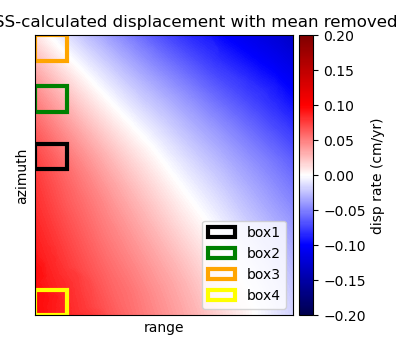

Mean GNSS-derived velocity in box1: 0.06280039 cm/yr


In [22]:
# read in los.r4 file
fileName = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/v_mean/los.r4'
f1 = gdal.Open(fileName, gdal.GA_ReadOnly)
losFull = f1.ReadAsArray()
f1 = None
# convert to cm/yr 
losFull = losFull/10.0

# cropped area
x1 = 18000
x2 = 14000
y1 = 2100
y2 = 1000

# crop out my area
los = losFull[y2:y1,x2:x1]
# subtract out the mean 
los = los - np.mean(los)

# plot it.
plt.figure(figsize=(4,3.5),tight_layout=True)
plt.imshow(los, aspect='auto',interpolation='nearest',vmin=-0.2,vmax=0.2)
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.set_cmap('seismic')
plt.gca().add_patch(Rectangle((box1x[0],box1y[0]),box1dx,box1dy,edgecolor='k',facecolor='none',lw=3,label='box1'))
plt.gca().add_patch(Rectangle((box2x[0],box2y[0]),box2dx,box2dy,edgecolor='green',facecolor='none',lw=3,label='box2'))
plt.gca().add_patch(Rectangle((box3x[0],box3y[0]),box3dx,box3dy,edgecolor='orange',facecolor='none',lw=3,label='box3'))
plt.gca().add_patch(Rectangle((box4x[0],box4y[0]),box4dx,box4dy,edgecolor='yellow',facecolor='none',lw=3,label='box4'))
plt.legend(loc='lower right')
plt.xlim([dx,0]); plt.ylim([dy,0])
plt.xlabel('range'); plt.ylabel('azimuth')
plt.xticks([]); plt.yticks([])
plt.title('LOS GNSS-calculated displacement with mean removed')
plt.show()

# pull out values for specific box and take mean 
losBox = np.mean(los[boxY[0]:boxY[1],boxX[0]:boxX[1]].flatten())
print('Mean GNSS-derived velocity in '+str(boxKey)+': '+str(losBox)+' cm/yr')


JUST PLOTTING mean and median for each range. Makes the ylim easier each time. 

/tmp/ipykernel_19587/3421588583.py:5: RuntimeWarning: Mean of empty slice
  plt.plot(amp_disp_centers,np.nanmean(amp_disp_masked,axis=1),'^',markersize=10,c='green',label='mean',zorder=5)
/home/ocp4/software/anaconda3/envs/oliviaJupyter/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/tmp/ipykernel_19587/3421588583.py:23: RuntimeWarning: Mean of empty slice
  plt.plot(wrap_err_centers,np.nanmean(wrap_err_masked,axis=1),'^',markersize=10,c='green',label='mean',zorder=5)
/home/ocp4/software/anaconda3/envs/oliviaJupyter/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


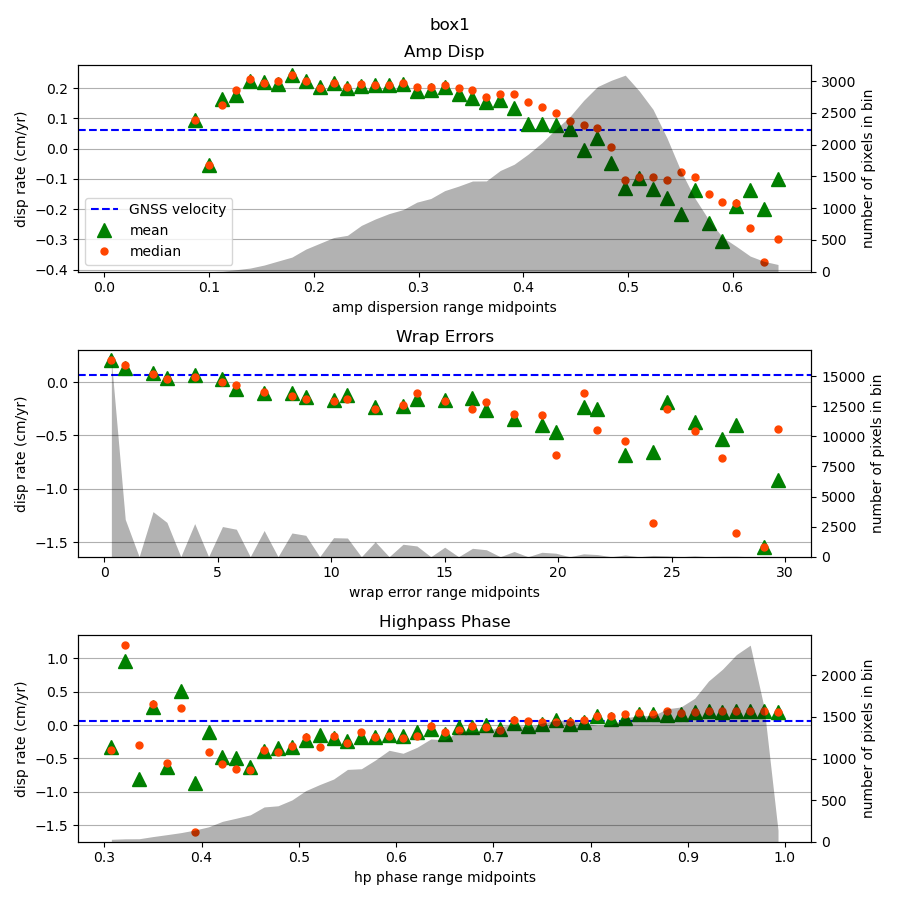

In [23]:
# plot it
plt.figure(figsize=(9,9),tight_layout=True)
ax1 = plt.subplot(3,1,1)
ax1.axhline(losBox,0,1,color='b',linestyle='--',label='GNSS velocity')
plt.plot(amp_disp_centers,np.nanmean(amp_disp_masked,axis=1),'^',markersize=10,c='green',label='mean',zorder=5)
plt.plot(amp_disp_centers,np.nanmedian(amp_disp_masked,axis=1),'.',markersize=10,c='orangered',label='median',zorder=10)
plt.legend(loc='lower left')
plt.xlabel('amp dispersion range midpoints')
plt.ylabel('disp rate (cm/yr)')
plt.grid(axis='y')
plt.title('Amp Disp')
ax2 = ax1.twinx()
lows = np.zeros(num_ranges)
ax2.fill_between(amp_disp_centers,lows,num_pix_amp_disp,color='k',alpha=0.3,zorder=0,linewidth=0)
ylow,yhigh = ax2.get_ylim()
plt.ylim([0,yhigh])
plt.ylabel('number of pixels in bin')
plt.xlabel('amp dispersion range midpoints')


ax1 = plt.subplot(3,1,2)
ax1.axhline(losBox,0,1,color='b',linestyle='--',label='GNSS velocity')
plt.plot(wrap_err_centers,np.nanmean(wrap_err_masked,axis=1),'^',markersize=10,c='green',label='mean',zorder=5)
plt.plot(wrap_err_centers,np.nanmedian(wrap_err_masked,axis=1),'.',markersize=10,c='orangered',label='median',zorder=10)
plt.xlabel('wrap error range midpoints')
plt.ylabel('disp rate (cm/yr)')
plt.grid(axis='y')
plt.title('Wrap Errors')
ax2 = ax1.twinx()
ax2.fill_between(wrap_err_centers,lows,num_pix_wrap_err,color='k',alpha=0.3,zorder=0,linewidth=0)
ylow,yhigh = ax2.get_ylim()
plt.ylim([0,yhigh])
plt.ylabel('number of pixels in bin')
plt.xlabel('wrap error range midpoints')

ax1 = plt.subplot(3,1,3)
ax1.axhline(losBox,0,1,color='b',linestyle='--',label='GNSS velocity')
plt.plot(hp_phs_centers,np.nanmean(hp_phs_masked,axis=1),'^',markersize=10,c='green',label='mean',zorder=5)
plt.plot(hp_phs_centers,np.nanmedian(hp_phs_masked,axis=1),'.',markersize=10,c='orangered',label='median',zorder=10)
plt.xlabel('hp phase range midpoints')
plt.ylabel('disp rate (cm/yr)')
plt.grid(axis='y')
plt.title('Highpass Phase')
ax2 = ax1.twinx()
ax2.fill_between(hp_phs_centers,lows,num_pix_hp_phs,color='k',alpha=0.3,zorder=-10,linewidth=0)
ylow,yhigh = ax2.get_ylim()
plt.ylim([0,yhigh])
plt.ylabel('number of pixels in bin')
plt.xlabel('highpass phase range midpoints')
plt.suptitle(boxKey)

plt.show()